In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from scipy import stats
from sklearn.linear_model import Ridge
from sklearn import tree

#Set torch seed
torch.manual_seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
geom_cols = ['A-SCORE', 'BOARD', 'GCSE-G-SCORE', 'GENDER', 'GTOT', 'GNUM', 'GCSE-MA-MAX', 'GCSE-MA-NUM', 'AGE', 'INST-GA-MN', 'INST-GA-SD', 'INSTTYPE', 'LEA', 'INSTITUTE', 'STUDENT']
df = pd.read_csv('/content/drive/My Drive/a-level-geometry.txt', sep=" ", header=None, names=geom_cols)
print(df.head())

   A-SCORE  BOARD  GCSE-G-SCORE  GENDER  ...  INSTTYPE  LEA  INSTITUTE  STUDENT
0      8.0      3             6       1  ...       7.0  1.0        1.0     25.0
1      8.0      3             6       1  ...       7.0  1.0        1.0     51.0
2      8.0      3             8       1  ...       7.0  1.0        1.0     69.0
3     10.0      3             8       1  ...       7.0  1.0        1.0     70.0
4      8.0      3             7       1  ...       7.0  1.0        1.0     85.0

[5 rows x 15 columns]


In [5]:
# utilising the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
#Create binary variable for Protected Group
df['PROTECTED'] = [1 if x == 1 else 0 for x in df['INSTTYPE']] 

#Create binary variable for achieving a C or above in A-Level Geometry
df['ABOVE_C'] = [1 if x >= 6 else 0 for x in df['A-SCORE']] 

In [7]:
df.groupby(["ABOVE_C", "PROTECTED"]).size()

ABOVE_C  PROTECTED
0        0             8040
         1             5774
1        0            12916
         1             6546
dtype: int64

In [8]:
# Create test and training set, apply standard scaler to non-binary variables

X = df[['GCSE-G-SCORE', 'GTOT', 'GNUM', 'GCSE-MA-MAX', 'GCSE-MA-NUM', 'AGE', 'INST-GA-MN', 'INST-GA-SD', 'GENDER', 'PROTECTED']].copy()
feature_names = list(X.columns)
y = df[['ABOVE_C']].copy()
feat_map = list(X.columns)
X = X.to_numpy()
y = y.to_numpy()
X, y = shuffle(X, y)

y = y.squeeze()

indices = range(len(X))
X_LR, X_val, y_LR, y_val, indx_LR, indx_val = train_test_split(X, y, indices, test_size=0.4, random_state=32)

indices2 = range(len(X_val))

X_s2, X_s1, y_s2, y_s1, indx_s2, indx_s1 = train_test_split(X_val, y_val, indices2, test_size=0.18, random_state=12)

scaler = StandardScaler()

X_LR[:, 0:7] = scaler.fit_transform(X_LR[:, 0:7])
X_val[:, 0:7] = scaler.fit_transform(X_val[:, 0:7])
X_s2[:, 0:7] = scaler.fit_transform(X_s2[:, 0:7])
X_s1[:, 0:7] = scaler.fit_transform(X_s1[:, 0:7])

training_features_tensor = torch.tensor(X_LR, requires_grad=False, dtype=torch.float)
training_labels_tensor = torch.tensor(y_LR, requires_grad=False, dtype=torch.float)

s1_features_tensor = torch.tensor(X_s1, requires_grad=False, dtype=torch.float)
s1_labels_tensor = torch.tensor(y_s1, requires_grad=False, dtype=torch.float)

s2_features_tensor = torch.tensor(X_s2, requires_grad=False, dtype=torch.float)
s2_labels_tensor = torch.tensor(y_s2, requires_grad=False, dtype=torch.float)

val_features_tensor = torch.tensor(X_val, requires_grad=False, dtype=torch.float)
val_labels_tensor = torch.tensor(y_val, requires_grad=False, dtype=torch.float)

In [9]:
def calc_FNR_FPR(y, y_pred):
    """
    Returns the FNR and FPR
    """
    y = y.numpy()
    y_pred = y_pred.numpy()
    fnr = 1 - y_pred[y == 1].mean()
    fpr = y_pred[y == 0].mean()
    
    return fnr, fpr

In [10]:
def plot_loss_accuracy(train_loss, valid_loss, train_acc, valid_acc, title):
    #plots the loss and accuracy of training and validation set during training
    fig = plt.figure(figsize=plt.figaspect(0.2))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(train_loss, 'b')
    ax1.plot(valid_loss, 'r')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.title(title)
    ax1.legend(['Train', 'Validation'])  
    
    ax1 = fig.add_subplot(1,2,2)
    ax1.plot(train_acc, 'b')
    ax1.plot(valid_acc, 'r')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    ax1.legend(['Train', 'Validation'])

In [11]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10, 1)
    
    def forward(self, x):
        pred_logit = self.linear(x)
        y_pred = torch.sigmoid(pred_logit)
        y_pred = torch.squeeze(y_pred)
        return y_pred

In [12]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0

    pred_probs = np.array([])
    preds      = np.array([])
    labs = np.array([])
    model.train()

    for i, data in enumerate(iterator, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        logits = model(inputs)
        pred_probs = np.append(pred_probs, logits.detach().cpu())
        loss = criterion(logits, labels)
        pred = torch.round(logits.detach().cpu().data) 
        acc = accuracy_score(labels.detach().cpu(), pred)
        preds = np.append(preds, pred.detach().cpu())
        labs = np.append(labs,labels.detach().cpu())
        
        loss.backward()
        optimizer.step()

        # capture loss and scores
        epoch_loss += loss.item()
        epoch_acc += acc.item()  
    
    f1 =  f1_score(labs,preds)
    auc = roc_auc_score(labs,pred_probs) 
            
    return epoch_loss/len(iterator) , epoch_acc / len(iterator), f1, auc

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    epoch_f1_o = 0
    epoch_f1_p = 0
    epoch_auc = 0
    epoch_prot_mean = 0
    epoch_other_mean = 0
    epoch_prot_fpr_mean = 0
    epoch_other_fpr_mean = 0
    epoch_prot_fnr_mean = 0
    epoch_other_fnr_mean = 0
    epoch_conf_matrices = np.zeros((2,2))
    epoch_acc_p = 0
    epoch_acc_o = 0

    pred_probs = np.array([])
    preds      = np.array([])
    labs = np.array([])
    model.eval()
    
    with torch.no_grad():
    
        for i, data in enumerate(iterator, 0):
            
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            probs = model(inputs)
            
            loss = criterion(probs, labels)
            
            pred = torch.round(probs.detach().cpu().data) 
            acc = accuracy_score(labels.detach().cpu(), pred)
            prot = inputs[:,feat_map.index('PROTECTED')] == 1
            other = inputs[:,feat_map.index('PROTECTED')] == 0
            acc_p = accuracy_score(labels.detach().cpu()[prot], pred[prot])
            acc_o = accuracy_score(labels.detach().cpu()[other], pred[other])
            f1_p = f1_score(labels.detach().cpu()[prot], pred[prot], zero_division=1)
            f1_o = f1_score(labels.detach().cpu()[other], pred[other], zero_division=1)
            prot_mean = pred[prot].mean()
            other_mean = pred[other].mean()

            # Check these expressions for fpr and fnr
            prot_fnr, prot_fpr = calc_FNR_FPR(labels.detach().cpu()[prot], pred[prot])
            other_fnr, other_fpr = calc_FNR_FPR(labels.detach().cpu()[other], pred[other])
            pred_probs = np.append(pred_probs, probs.detach().cpu())
            preds = np.append(preds, pred.detach().cpu())
            labs = np.append(labs,labels.detach().cpu())
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_prot_mean += prot_mean
            epoch_other_mean += other_mean
            epoch_prot_fpr_mean += prot_fpr
            epoch_other_fpr_mean += other_fpr
            epoch_prot_fnr_mean += prot_fnr
            epoch_other_fnr_mean += other_fnr
            epoch_acc_p += acc_p
            epoch_acc_o += acc_o
            epoch_f1_o += f1_o
            epoch_f1_p += f1_p


    f1 =  f1_score(labs,preds)
    auc = roc_auc_score(labs,pred_probs) 

    n = len(iterator)
    return epoch_loss/n , epoch_acc /n, f1, auc, preds, pred_probs, epoch_prot_mean/n, epoch_other_mean/n, epoch_prot_fpr_mean/n, epoch_other_fpr_mean/n, epoch_prot_fnr_mean/n, epoch_other_fnr_mean/n, epoch_acc_p/n, epoch_acc_o/n, epoch_f1_p/n, epoch_f1_o/n

In [13]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [14]:
## Unbalanced classes: apply class weights for both the predictor and the discriminator
neg_weight = y[y == 1].size /y[y == 0].size
class_weights = torch.as_tensor(neg_weight)

neg_A_weight = X[:,9][X[:,9] == 1].size /X[:,9][X[:,9] == 0].size
class_weights_A = torch.as_tensor(neg_A_weight)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.797 | Train Acc: 71.04%
	 Val. Loss: 0.800 |  Val. Acc: 70.84%
	 Val Protected FPR: 0.411
	 Val Other FPR: 0.636
	 Val Protected FNR: 0.172
	 Val Other FNR: 0.069
Epoch: 11 | Epoch Time: 0m 0s
	Train Loss: 0.725 | Train Acc: 74.68%
	 Val. Loss: 0.730 |  Val. Acc: 74.18%
	 Val Protected FPR: 0.291
	 Val Other FPR: 0.459
	 Val Protected FNR: 0.241
	 Val Other FNR: 0.119
Epoch: 21 | Epoch Time: 0m 0s
	Train Loss: 0.709 | Train Acc: 75.15%
	 Val. Loss: 0.712 |  Val. Acc: 74.79%
	 Val Protected FPR: 0.280
	 Val Other FPR: 0.423
	 Val Protected FNR: 0.245
	 Val Other FNR: 0.133
Epoch: 31 | Epoch Time: 0m 0s
	Train Loss: 0.703 | Train Acc: 75.22%
	 Val. Loss: 0.704 |  Val. Acc: 75.12%
	 Val Protected FPR: 0.285
	 Val Other FPR: 0.403
	 Val Protected FNR: 0.240
	 Val Other FNR: 0.136
Epoch: 41 | Epoch Time: 0m 0s
	Train Loss: 0.699 | Train Acc: 75.36%
	 Val. Loss: 0.700 |  Val. Acc: 75.30%
	 Val Protected FPR: 0.291
	 Val Other FPR: 0.397
	 Val Prot

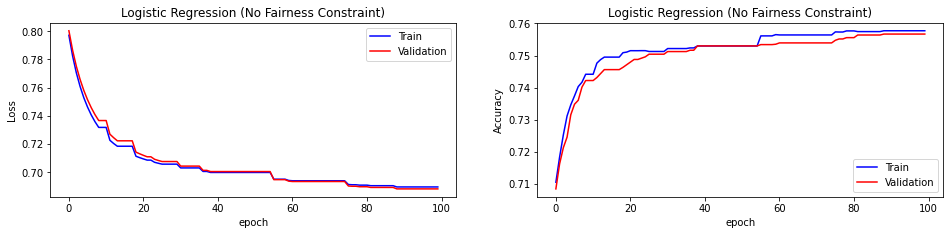

In [15]:
LR_f1s = []
LR_fnr_diffs = []
LR_fpr_diffs = []
LR_aucs = []
LR_accs = []
LR_accs_o = []
LR_accs_p = []
e_valid_acc = 0
epochs = 100
lr = 0.0001
batch_size = 64


e_valid_acc = 0
e_valid_fnr_fpr = 1

# create Tensor datasets
train_data = torch.utils.data.TensorDataset(training_features_tensor, training_labels_tensor)
val_data = torch.utils.data.TensorDataset(s1_features_tensor, s1_labels_tensor)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last = False)
valid_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last = False)

model = LogisticRegression().to(device)

# loss function - using cross entropy loss
criterion = nn.BCELoss(weight = class_weights)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
train_accs = []
val_losses = []
val_accs = []


for epoch in range(epochs):

    start_time = time.time()

    train_loss, train_acc, train_f1, train_auc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc, valid_f1, valid_auc, preds, pred_probs, p_mean, o_mean, p_fpr, o_fpr, p_fnr, o_fnr, acc_p, acc_o, f1_p, f1_o = evaluate(model, valid_loader, criterion)

    fnr_diff = np.abs((o_fnr - p_fnr))
    fpr_diff = np.abs((o_fpr - p_fpr))


    if valid_acc > e_valid_acc:
        e_train_loss = train_loss
        e_train_acc = train_acc
        e_train_f1 = train_f1
        e_train_auc = train_auc
        e_valid_acc = valid_acc
        e_valid_loss = valid_loss
        e_valid_f1 = valid_f1
        e_valid_auc = valid_auc
        e_valid_fnr_diff = fnr_diff
        e_valid_fpr_diff = fpr_diff
        e_valid_o_fnr = o_fnr
        e_valid_o_fpr = o_fpr
        e_valid_p_fnr = p_fnr
        e_valid_p_fpr = p_fpr
        e_valid_o_acc = acc_o
        e_valid_p_acc = acc_p
        e_valid_o_f1 = f1_o
        e_valid_p_f1 = f1_p
        best_epoch = epoch
        torch.save({'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': e_valid_loss,
        }, 'best_LR_model.pt')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if epoch%(epochs//10) == 0:

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        print(f'\t Val Protected FPR: {p_fpr:.3f}')
        print(f'\t Val Other FPR: {o_fpr:.3f}')
        print(f'\t Val Protected FNR: {p_fnr:.3f}')
        print(f'\t Val Other FNR: {o_fnr:.3f}')

    train_losses.append(e_train_loss)
    train_accs.append(e_train_acc)

    val_losses.append(e_valid_loss)
    val_accs.append(e_valid_acc)

title = "Logistic Regression (No Fairness Constraint)"
plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs, title)

LR_f1s.append(e_valid_f1)
LR_fnr_diffs.append(e_valid_fnr_diff)
LR_fpr_diffs.append(e_valid_fpr_diff)
LR_aucs.append(e_valid_auc)
LR_accs.append(e_valid_acc)
LR_accs_o.append(e_valid_o_acc)
LR_accs_p.append(e_valid_p_acc)
    
    

In [16]:
# Load best model
deployed_path = 'best_LR_model.pt'
model = LogisticRegression()
batch_size = 64
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001)
criterion = nn.BCEWithLogitsLoss(weight = class_weights)
best_checkpoint = torch.load(deployed_path)
model.load_state_dict(best_checkpoint['model_state_dict'])
optimizer.load_state_dict(best_checkpoint['optimizer_state_dict'])
epoch = best_checkpoint['epoch']
loss = best_checkpoint['loss']

s2_data = torch.utils.data.TensorDataset(s2_features_tensor, s2_labels_tensor)
s2_loader = torch.utils.data.DataLoader(s2_data, shuffle=False, batch_size=batch_size, drop_last = False)

valid_loss, valid_acc, valid_f1, valid_auc, preds, pred_probs, p_mean, o_mean, p_fpr, o_fpr, p_fnr, o_fnr, acc_p, acc_o, f1_p, f1_o = evaluate(model, s2_loader, criterion)

In [17]:
# Put data into format required for post-processing
prot = (X_s2[:,feat_map.index('PROTECTED')] == 1).astype(int)

data = np.concatenate((np.expand_dims(pred_probs, 1), np.expand_dims(y_s2, 1), np.expand_dims(prot, 1)), axis=1)

test_and_val_data = pd.DataFrame(data=data, columns = ['prediction','label', 'group'])

print(test_and_val_data)

       prediction  label  group
0        0.808506    1.0    0.0
1        0.941869    1.0    0.0
2        0.715251    0.0    1.0
3        0.762015    1.0    1.0
4        0.520473    0.0    1.0
...           ...    ...    ...
10910    0.880382    1.0    0.0
10911    0.597908    1.0    1.0
10912    0.672738    1.0    1.0
10913    0.971006    1.0    0.0
10914    0.479152    1.0    0.0

[10915 rows x 3 columns]


In [18]:
# This section of code is from Pleiss et al. 2015
# (https://github.com/gpleiss/equalized_odds_and_calibration/blob/master/eq_odds.py)

import cvxpy as cvx
import numpy as np
from collections import namedtuple


class Model(namedtuple('Model', 'pred label')):
    def logits(self):
        raw_logits = np.clip(np.log(self.pred / (1 - self.pred)), -100, 100)
        return raw_logits

    def num_samples(self):
        return len(self.pred)

    def base_rate(self):
        """
        Percentage of samples belonging to the positive class
        """
        return np.mean(self.label)

    def accuracy(self):
        return self.accuracies().mean()

    def precision(self):
        return (self.label[self.pred.round() == 1]).mean()

    def recall(self):
        return (self.label[self.label == 1].round()).mean()

    def tpr(self):
        """
        True positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 1))

    def fpr(self):
        """
        False positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 0))

    def tnr(self):
        """
        True negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 0))

    def fnr(self):
        """
        False negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 1))

    def fn_cost(self):
        """
        Generalized false negative cost
        """
        return 1 - self.pred[self.label == 1].mean()

    def fp_cost(self):
        """
        Generalized false positive cost
        """
        return self.pred[self.label == 0].mean()

    def accuracies(self):
        return self.pred.round() == self.label
    
    def f1(self):
        return f1_score(self.label, self.pred.round())

    def auc(self):
        return roc_auc_score(self.label, self.pred.round())

    def eq_odds(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)

        self_fair_pred = self.pred.copy()
        self_pp_indices, = np.nonzero(self.pred.round())
        self_pn_indices, = np.nonzero(1 - self.pred.round())
        np.random.shuffle(self_pp_indices)
        np.random.shuffle(self_pn_indices)

        n2p_indices = self_pn_indices[:int(len(self_pn_indices) * sn2p)]
        self_fair_pred[n2p_indices] = 1 - self_fair_pred[n2p_indices]
        p2n_indices = self_pp_indices[:int(len(self_pp_indices) * (1 - sp2p))]
        self_fair_pred[p2n_indices] = 1 - self_fair_pred[p2n_indices]

        othr_fair_pred = othr.pred.copy()
        othr_pp_indices, = np.nonzero(othr.pred.round())
        othr_pn_indices, = np.nonzero(1 - othr.pred.round())
        np.random.shuffle(othr_pp_indices)
        np.random.shuffle(othr_pn_indices)

        n2p_indices = othr_pn_indices[:int(len(othr_pn_indices) * on2p)]
        othr_fair_pred[n2p_indices] = 1 - othr_fair_pred[n2p_indices]
        p2n_indices = othr_pp_indices[:int(len(othr_pp_indices) * (1 - op2p))]
        othr_fair_pred[p2n_indices] = 1 - othr_fair_pred[p2n_indices]

        fair_self = Model(self_fair_pred, self.label)
        fair_othr = Model(othr_fair_pred, othr.label)

        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr

    def eq_odds_optimal_mix_rates(self, othr):
        sbr = float(self.base_rate())
        obr = float(othr.base_rate())

        sp2p = cvx.Variable(1)
        sp2n = cvx.Variable(1)
        sn2p = cvx.Variable(1)
        sn2n = cvx.Variable(1)

        op2p = cvx.Variable(1)
        op2n = cvx.Variable(1)
        on2p = cvx.Variable(1)
        on2n = cvx.Variable(1)

        sfpr = self.fpr() * sp2p + self.tnr() * sn2p
        sfnr = self.fnr() * sn2n + self.tpr() * sp2n
        ofpr = othr.fpr() * op2p + othr.tnr() * on2p
        ofnr = othr.fnr() * on2n + othr.tpr() * op2n
        error = sfpr + sfnr + ofpr + ofnr

        sflip = 1 - self.pred
        sconst = self.pred
        oflip = 1 - othr.pred
        oconst = othr.pred

        sm_tn = np.logical_and(self.pred.round() == 0, self.label == 0)
        sm_fn = np.logical_and(self.pred.round() == 0, self.label == 1)
        sm_tp = np.logical_and(self.pred.round() == 1, self.label == 1)
        sm_fp = np.logical_and(self.pred.round() == 1, self.label == 0)

        om_tn = np.logical_and(othr.pred.round() == 0, othr.label == 0)
        om_fn = np.logical_and(othr.pred.round() == 0, othr.label == 1)
        om_tp = np.logical_and(othr.pred.round() == 1, othr.label == 1)
        om_fp = np.logical_and(othr.pred.round() == 1, othr.label == 0)

        spn_given_p = (sn2p * (sflip * sm_fn).mean() + sn2n * (sconst * sm_fn).mean()) / sbr + \
                      (sp2p * (sconst * sm_tp).mean() + sp2n * (sflip * sm_tp).mean()) / sbr

        spp_given_n = (sp2n * (sflip * sm_fp).mean() + sp2p * (sconst * sm_fp).mean()) / (1 - sbr) + \
                      (sn2p * (sflip * sm_tn).mean() + sn2n * (sconst * sm_tn).mean()) / (1 - sbr)

        opn_given_p = (on2p * (oflip * om_fn).mean() + on2n * (oconst * om_fn).mean()) / obr + \
                      (op2p * (oconst * om_tp).mean() + op2n * (oflip * om_tp).mean()) / obr

        opp_given_n = (op2n * (oflip * om_fp).mean() + op2p * (oconst * om_fp).mean()) / (1 - obr) + \
                      (on2p * (oflip * om_tn).mean() + on2n * (oconst * om_tn).mean()) / (1 - obr)

        constraints = [
            sp2p == 1 - sp2n,
            sn2p == 1 - sn2n,
            op2p == 1 - op2n,
            on2p == 1 - on2n,
            sp2p <= 1,
            sp2p >= 0,
            sn2p <= 1,
            sn2p >= 0,
            op2p <= 1,
            op2p >= 0,
            on2p <= 1,
            on2p >= 0,
            spp_given_n == opp_given_n,
            spn_given_p == opn_given_p,
        ]

        prob = cvx.Problem(cvx.Minimize(error), constraints)
        prob.solve()

        res = np.array([sp2p.value, sn2p.value, op2p.value, on2p.value])
        return res

    def __repr__(self):
        return '\n'.join([
            'Accuracy:\t%.3f' % self.accuracy(),
            'F.P. cost:\t%.3f' % self.fp_cost(),
            'F.N. cost:\t%.3f' % self.fn_cost(),
            'Base rate:\t%.3f' % self.base_rate(),
            'Avg. score:\t%.3f' % self.pred.mean(),
            'F1 score:\t%.3f' % self.f1(),
            'AUC score:\t%.3f' % self.auc(),
        ])

In [19]:
# Calculate overall metrics

kf = KFold(n_splits=10)

accs = []
aucs = []
f1s = []
fnr_fpr_diffs = []
prot_accs = []
other_accs = []
fnr_prots = []
fnr_others = []
fpr_prots = []
fpr_others = []



for train_index, test_index in kf.split(test_and_val_data):

    # Randomly split the data into two sets - one for computing the fairness constants
    order = np.random.permutation(len(test_and_val_data))
    val_indices = train_index
    test_indices = test_index
    val_data = test_and_val_data.iloc[val_indices]
    test_data = test_and_val_data.iloc[test_indices]

    # Create model objects - one for each group, validation and test
    group_0_val_data = val_data[val_data['group'] == 0]
    group_1_val_data = val_data[val_data['group'] == 1]
    group_0_test_data = test_data[test_data['group'] == 0]
    group_1_test_data = test_data[test_data['group'] == 1]

    group_0_val_model = Model(group_0_val_data['prediction'].values, group_0_val_data['label'].values)
    group_1_val_model = Model(group_1_val_data['prediction'].values, group_1_val_data['label'].values)
    group_0_test_model = Model(group_0_test_data['prediction'].values, group_0_test_data['label'].values)
    group_1_test_model = Model(group_1_test_data['prediction'].values, group_1_test_data['label'].values)

    # Find mixing rates for equalized odds models
    _, _, mix_rates = Model.eq_odds(group_0_val_model, group_1_val_model)

    # Apply the mixing rates to the test models
    eq_odds_group_0_test_model, eq_odds_group_1_test_model = Model.eq_odds(group_0_test_model,
                                                                            group_1_test_model,
                                                                            mix_rates)
    prop_prot = np.mean(prot)
    prop_other = 1- prop_prot
    acc = (prop_prot*eq_odds_group_1_test_model.accuracy())+ (prop_other*eq_odds_group_0_test_model.accuracy())
    f1 = (prop_prot*eq_odds_group_1_test_model.f1())+ (prop_other*eq_odds_group_0_test_model.f1())
    auc = (prop_prot*eq_odds_group_1_test_model.auc())+ (prop_other*eq_odds_group_0_test_model.auc())

    fnr_diff = np.absolute(eq_odds_group_0_test_model.fn_cost() - eq_odds_group_1_test_model.fn_cost())
    fpr_diff = np.absolute(eq_odds_group_0_test_model.fp_cost() - eq_odds_group_1_test_model.fp_cost())
    fnr_fpr_diff = (fnr_diff + fpr_diff)/2

    accs.append(acc)
    aucs.append(auc)
    f1s.append(f1)
    fnr_fpr_diffs.append(fnr_fpr_diff)
    prot_accs.append(eq_odds_group_1_test_model.accuracy())
    other_accs.append(eq_odds_group_0_test_model.accuracy())
    fnr_prots.append(eq_odds_group_1_test_model.fn_cost())
    fpr_prots.append(eq_odds_group_1_test_model.fp_cost())
    fnr_others.append(eq_odds_group_0_test_model.fn_cost())
    fpr_others.append(eq_odds_group_0_test_model.fp_cost())


In [20]:
print("Mean Accuracy: ", np.mean(accs))
print("Std Accuracy: ", np.std(accs))
print("Mean F1: ", np.mean(f1s))
print("Std F1: ", np.std(f1s))
print("Mean AUC: ", np.mean(aucs))
print("Std AUC: ", np.std(aucs))
print("Mean FNR FPR Diff: ", np.mean(fnr_fpr_diffs))
print("Std FNR FPR Diff: ", np.std(fnr_fpr_diffs))
print("Mean FNR Prot: ", np.mean(fnr_prots))
print("Std FNR Prot: ", np.std(fnr_prots))
print("Mean FNR Other: ", np.mean(fnr_others))
print("Std FNR Other: ", np.std(fnr_others))
print("Mean FPR Prot: ", np.mean(fpr_prots))
print("Std FPR Prot: ", np.std(fpr_prots))
print("Mean FPR Other: ", np.mean(fpr_others))
print("Std FPR Other: ", np.std(fpr_others))
print("Mean Prot Accuracy: ", np.mean(prot_accs))
print("Std Prot Accuracy: ", np.std(prot_accs))
print("Mean Other Accuracy: ", np.mean(other_accs))
print("Std Other Accuracy: ", np.std(other_accs))

Mean Accuracy:  0.7243415554679459
Std Accuracy:  0.009132132563007673
Mean F1:  0.7634257668818673
Std F1:  0.008954567363959253
Mean AUC:  0.7180586425165322
Std AUC:  0.010832657983656494
Mean FNR FPR Diff:  0.01693424885017922
Std FNR FPR Diff:  0.009028115222139501
Mean FNR Prot:  0.3216584247230267
Std FNR Prot:  0.022516747394260263
Mean FNR Other:  0.31813862830284334
Std FNR Other:  0.008593067164273663
Mean FPR Prot:  0.3936490482445092
Std FPR Prot:  0.018436335651713705
Mean FPR Other:  0.3962763821099968
Std FPR Other:  0.013588557692050876
Mean Prot Accuracy:  0.7215691134852342
Std Prot Accuracy:  0.024630522045717848
Mean Other Accuracy:  0.726006240206832
Std Other Accuracy:  0.01609613375857208
